# Project 4
______

In [131]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTEN
from imblearn.combine import SMOTEENN

## COVID Hospitalization

### Binary classification model tuning

Here we will attempt to create a model for hospitalization predictions based on demographic data as well time of the year (month).

In [172]:
df_surv_hosp=pd.read_csv('../data/clean_data/covid_surveillance_hospitalization.csv')

In [173]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No


In [174]:
df_surv_hosp.shape

(114644, 9)

**Creating month as a new feature**

In [176]:
def create_month(df):
    
    #converting case_month to DateTime
    df['case_month']=pd.to_datetime(df['case_month'])

    #Extracting month as a feature for the model
    df['month']=df['case_month'].dt.month

    #All our columns will be treated as categorical. Converting month column to object type.
    df['month']=df['month'].astype(object)

    return df

In [177]:
df_surv_hosp=create_month(df_surv_hosp)

In [137]:
#binarizing target variable - hosp_yn
# df_surv_hosp['hosp_yn']=df_surv_hosp['hosp_yn'].map(lambda x: 1 if x=='Yes' else 0)

In [178]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn,month
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3


### Baseline- Model Benchmark

In [17]:
df_surv_hosp['hosp_yn'].value_counts(normalize=True)

0    0.919411
1    0.080589
Name: hosp_yn, dtype: float64

We have highly imbalanced classes for our target variable.  
Our baseline accuracy is 92%

In [18]:
#Creating X and y
X=df_surv_hosp.drop(columns=['case_month','symptom_status','death_yn','hosp_yn'])
y=df_surv_hosp['hosp_yn']
features=list(X.columns)

In [19]:
X.shape, y.shape

((114644, 6), (114644,))

In [20]:
X.head()

,res_state,age_group,sex,race,ethnicity,month
0,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,3
1,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,3
2,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3
3,PA,65+ years,Female,White,Non-Hispanic/Latino,3
4,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3


In [21]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: hosp_yn, dtype: int64

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y, random_state=42)

In [23]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((85983, 6), (85983,), (28661, 6), (28661,))

**One hot encoding train and test**

Defining function to transform train and test sets:

In [157]:
def transform_train(df):
    '''This function gets dummies for features 
    and saves column lists of dummies for training set'''
       
    #getting list of columns without dropping as a guide for reference:
    col_wo_drop=pd.get_dummies(df)
    dropped_col_guide=col_wo_drop.columns

    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    
    #saving list of dummy columns
    df_dummies = [col for col in df_dum if "_" in col and col.rsplit("_",1)[0] in features]
    
    return ( dropped_col_guide, df_dum, df_dummies)

In [160]:
def transform_test(df, df_dummies):
    '''This function gets dummies for features 
    for training set and removes the columns not created during training
    and adds the columns missing from test set'''
        
    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    #Removing additional dummy columns
    for col in df_dum.columns:
        if ("_" in col) and (col.rsplit("_",1)[0] in features) and col not in df_dummies:
            print("Removing additional feature {}".format(col))
            df_dum.drop(col, axis=1, inplace=True)
            
    #Adding missing columns        
    for col in df_dummies:
        if col not in df_dum.columns:
            print("Adding missing feature {}".format(col))
            df_dum[col] = 0
    
    return df_dum

In [26]:
dropped_col_guide, X_train_dum, X_train_dummies=transform_train(X_train)

C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [27]:
X_train_dum.head()

,res_state_AL,res_state_AR,res_state_AZ,res_state_CA,res_state_CO,res_state_CT,res_state_DC,res_state_FL,res_state_GA,res_state_IA,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
73768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
106870,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
78656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1882,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [28]:
X_test_dum=transform_test(X_test, X_train_dummies)

Removing additional feature res_state_HI


C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [29]:
X_train_dum.shape, y_train.shape, X_test_dum.shape, y_test.shape

((85983, 63), (85983,), (28661, 63), (28661,))

In [30]:
X_test_dum=X_test_dum[X_train_dummies]

In [31]:
X_train_dum.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85983 entries, 73768 to 9539
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   res_state_AL                                 85983 non-null  uint8
 1   res_state_AR                                 85983 non-null  uint8
 2   res_state_AZ                                 85983 non-null  uint8
 3   res_state_CA                                 85983 non-null  uint8
 4   res_state_CO                                 85983 non-null  uint8
 5   res_state_CT                                 85983 non-null  uint8
 6   res_state_DC                                 85983 non-null  uint8
 7   res_state_FL                                 85983 non-null  uint8
 8   res_state_GA                                 85983 non-null  uint8
 9   res_state_IA                                 85983 non-null  uint8
 10  res_state_ID       

**Model 1: Logistic Regression**

In [55]:
logreg=LogisticRegression(random_state=42,n_jobs=-1)

# logreg_param={ 
    # 'logreg__
# }

In [56]:
logreg.fit(X_train_dum, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [64]:
eval_df=pd.DataFrame(columns=['model_no', 'comment', 'training_accuracy', 'testing_accuracy', 'f1score_train', 'f1score_test', 'balanced_accuracy', 'recall', 'precision'])

In [77]:
def model_eval(model, model_no, X_train, y_train, X_test, y_test, comment):
    
    
    ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, cmap='Blues')
        
    print(f'Model: {model}')
    #Calculating accuracy score
    training_accuracy=model.score(X_train, y_train)
    print(f'Training_score: {training_accuracy}')
    testing_accuracy=model.score(X_test, y_test)
    print(f'Testing score: {testing_accuracy}')
    

    #Calculating F1 scores
    pred_train=model.predict(X_train)
    pred=model.predict(X_test)
    f1score_train=f1_score(y_train,pred_train)
    print(f'F1 Train score: {f1score_train}')
    f1score_test=f1_score(y_test,pred)
    print(f'F1 Test score: {f1score_test}')
    
    balanced_accuracy=balanced_accuracy_score(y_test, pred)
    print(f'Balanced Accuracy: {balanced_accuracy}')  
    recall=recall_score(y_test, pred, pos_label = 1)
    print(f'Recall: {recall}')   
    precision=precision_score(y_test, pred, pos_label = 1)
    print(f'Precision: {precision}')
    #Saving metrics
    eval_df.loc[model_no-1,:]=[ model_no, comment, training_accuracy, testing_accuracy, f1score_train, f1score_test, balanced_accuracy, recall, precision]
    eval_df.to_csv('../data/covid_demo_model_evaluation.csv')
    
    return eval_df

Model: LogisticRegression(n_jobs=-1, random_state=42)
Training_score: 0.9218915366991149
Testing score: 0.9212867659886257
F1 Train score: 0.12574850299401197
F1 Test score: 0.11529411764705882
Balanced Accuracy: 0.5300535429050476
Recall: 0.06363636363636363
Precision: 0.6125


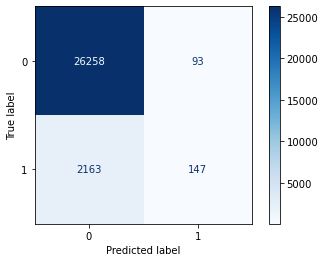

In [78]:
evaluation_df=model_eval(logreg, 1, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression')

We have very low F1 score because the data is highly imbalanced. Will try some undersampling and oversampling techniques


**Model 2: Undersampling majority class- Logistic Regression**

In [69]:
#Help from lesson 7.06
rus=RandomUnderSampler(random_state=42)

X_train_rus,y_train_rus=rus.fit_resample(X_train_dum,y_train)

In [70]:
X_train_rus.shape, y_train_rus.shape

((13858, 63), (13858,))

In [71]:
logreg_under=LogisticRegression(solver='liblinear')

logreg_under.fit(X_train_rus,y_train_rus)

LogisticRegression(solver='liblinear')

Model: LogisticRegression(solver='liblinear')
Training_score: 0.7497474383027853
Testing score: 0.7529395345591571
F1 Train score: 0.7510409188801147
F1 Test score: 0.3274764934941589
Balanced Accuracy: 0.7499200684203151
Recall: 0.7463203463203463
Precision: 0.20975787808735855


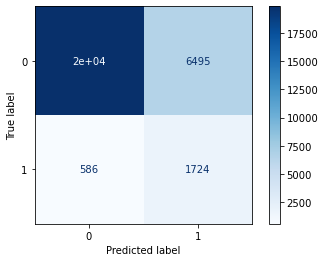

In [79]:
evaluation_df=model_eval(logreg_under, 2, X_train_rus, y_train_rus, X_test_dum, y_test, 'logistic regression with undersampling')

Teh F1-score seemed to improve a lot with undersampling

**Model 3: ADASYN-Logistic Regression**

In [81]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1))
])

logreg_ada_param={
    'ada__sampling_strategy':[0.5,.75,1]}
   

gs_ada=GridSearchCV(pipe,
               param_grid=logreg_ada_param,
                scoring='balanced_accuracy',
               cv=5)

In [82]:
gs_ada.fit(X_train_dum, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')
Training_score: 0.7507074135488199
Testing score: 0.7429725922819164
F1 Train score: 0.33219789132197886
F1 Test score: 0.32525213343677273
Balanced Accuracy: 0.7429725922819164
Recall: 0.7259740259740259
Precision: 0.20957260684828793


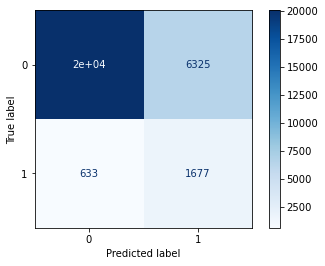

In [83]:
evaluation_df=model_eval(gs_ada, 3, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression with ADASYN')

In [85]:
gs_ada.best_params_

{'ada__sampling_strategy': 1}

**Model 4: ADASYN-Logistic Regression without GridSearch**

In [86]:
ada2=ADASYN(random_state=42)
X_train_ada,y_train_ada=ada2.fit_resample(X=X_train_dum, y=y_train)

In [87]:
logreg_ada=LogisticRegression(solver='liblinear', max_iter=500)

logreg_ada.fit(X_train_ada,y_train_ada)

LogisticRegression(max_iter=500, solver='liblinear')

Model: LogisticRegression(max_iter=500, solver='liblinear')
Training_score: 0.7580914879250832
Testing score: 0.7581731272460835
F1 Train score: 0.7571843903798526
F1 Test score: 0.3247929858743303
Balanced Accuracy: 0.7415101507602742
Recall: 0.7216450216450216
Precision: 0.20955373978629793


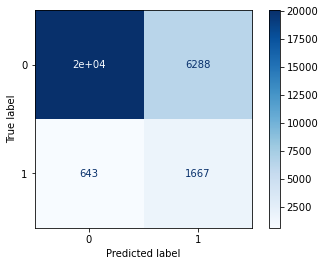

In [89]:
evaluation_df=model_eval(logreg_ada, 4, X_train_ada, y_train_ada, X_test_dum, y_test, 'logistic regression with ADASYN2')

**Model 4: KNeighbors with SMOTENN**  
Since the features are all categorical, trying SMOTENN(combination of over and under sampling)  
help from: https://imbalanced-learn.org/stable/combine.html#combine

In [34]:
sm= SMOTEENN(random_state=42)

In [35]:
X_train_sm,y_train_sm=sm.fit_resample(X_train_dum,y_train)

In [36]:
knn=KNeighborsClassifier()

In [49]:
pipe=Pipeline([
    ('sm', SMOTEENN(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_param={
    'sm__sampling_strategy':[.75,1],
    'knn__n_neighbors':[5,10,15],
    # 'knn__weights': ['uniform','distance'], 
    # 'knn__p':[1,2]
    }

gs_knn=GridSearchCV(pipe,
                   param_grid=knn_param,
                   scoring='balanced_accuracy',
                   cv=5)

In [50]:
gs_knn.fit(X_train_dum,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTEENN(random_state=42)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__n_neighbors': [5, 10, 15],
                         'sm__sampling_strategy': [0.75, 1]},
             scoring='balanced_accuracy')

Model: KNeighborsClassifier()
Training_score: 0.694055750823441
Testing score: 0.918983985206378
F1 Train score: 0.5299551691346285
F1 Test score: 0.2855384615384615
Balanced Accuracy: 0.5914009851355683
Recall: 0.20086580086580086
Precision: 0.49361702127659574


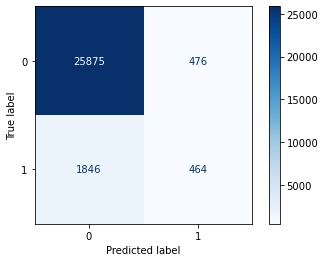

In [115]:
evaluation_df=model_eval(knn, 4, X_train_sm, y_train_sm, X_test_dum, y_test, 'KNN with SMOTENN')

In [96]:
gs_knn.best_params_

{'knn__n_neighbors': 10, 'sm__sampling_strategy': 1}

**Model 5: Naive Bayes with SMOTENN**

In [91]:
nb=MultinomialNB()

In [92]:
nb.fit(X_train_sm,y_train_sm)

MultinomialNB()

Model: MultinomialNB()
Training_score: 0.6635939606958905
Testing score: 0.9016084574857821
F1 Train score: 0.481145584725537
F1 Test score: 0.1561938958707361
Balanced Accuracy: 0.5418640806652647
Recall: 0.11298701298701298
Precision: 0.25290697674418605


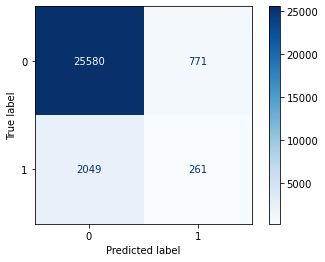

In [114]:
evaluation_df=model_eval(nb, 5, X_train_sm, y_train_sm, X_test_dum, y_test, 'MNB with SMOTENN')

**Model 6: Ada BOOST with ADASYN**

In [108]:

pipe_adab=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('adab', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)),
])

adab_param={
     'ada__sampling_strategy':[.8,1],
    'adab__n_estimators': [50,100],
    'adab__base_estimator__max_depth':[1,3],
    'adab__base_estimator__min_samples_split':[2,3],
    'adab__learning_rate':[0.9,1.0],
       
          
    }


gs_adab=GridSearchCV(pipe_adab,
                  param_grid=adab_param,
                  cv=3,
                  n_jobs=-1)


gs_adab.fit(X_train_dum,y_train);


Model: GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('adab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__sampling_strategy': [0.8, 1],
                         'adab__base_estimator__max_depth': [1, 3],
                         'adab__base_estimator__min_samples_split': [2, 3],
                         'adab__learning_rate': [0.9, 1.0],
                         'adab__n_estimators': [50, 100]})
Training_score: 0.8081830129211588
Testing score: 0.8053103520463347
F1 Train score: 0.34178073991299834
F1 Test score: 0.3350810295519543
Balanced Accuracy: 0.7156037187610942
Recall: 0.6086580086580087
Precision: 0.23117395593554751


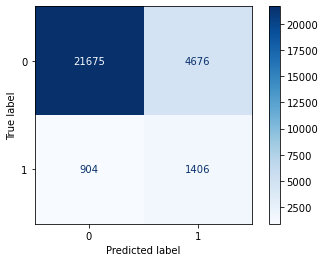

In [109]:
evaluation_df=model_eval(gs_adab, 6, X_train_dum, y_train, X_test_dum, y_test, 'AdaBoost with ADASYN')

In [110]:
gs_adab.best_estimator_

Pipeline(steps=[('ada', ADASYN(random_state=42, sampling_strategy=0.8)),
                ('adab',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.9, random_state=42))])

In [117]:
evaluation_df

,model_no,comment,training_accuracy,testing_accuracy,f1score_train,f1score_test,balanced_accuracy,recall,precision
0,1,logistic regression,0.921892,0.921287,0.125749,0.115294,0.530054,0.063636,0.6125
1,2,logistic regression with undersampling,0.749747,0.75294,0.751041,0.327476,0.74992,0.74632,0.209758
2,3,logistic regression with ADASYN,0.750707,0.742973,0.332198,0.325252,0.742973,0.725974,0.209573
3,4,KNN with SMOTENN,0.694056,0.918984,0.529955,0.285538,0.591401,0.200866,0.493617
4,5,MNB with SMOTENN,0.663594,0.901608,0.481146,0.156194,0.541864,0.112987,0.252907
5,6,AdaBoost with ADASYN,0.808183,0.80531,0.341781,0.335081,0.715604,0.608658,0.231174


## Binary classification including Symptom_status
**Complete hosp data (removed/unknown imputed as 0)**

In [161]:
df_surv_hosp2=pd.read_csv('../data/clean_data/covid_surveillance_hospitalization_comp.csv')

In [162]:
df_surv_hosp2.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Unknown
1,2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,0,No
2,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
3,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
4,2020-03-01,IA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Missing


In [141]:
df_surv_hosp2=df_surv_hosp[(df_surv_hosp['symptom_status']!='Missing') & (df_surv_hosp['symptom_status']!='Unknown')].copy()

In [144]:
df_surv_hosp2.shape

(77908, 10)

In [145]:
df_surv_hosp2['hosp_yn'].value_counts(normalize=True)

0    0.92916
1    0.07084
Name: hosp_yn, dtype: float64

We have highly imbalanced classes for our target variable.  
Our baseline accuracy is 93%

In [146]:
#Creating X and y
X2=df_surv_hosp2.drop(columns=['case_month','death_yn','hosp_yn'])
y2=df_surv_hosp2['hosp_yn']
features=list(X2.columns)

In [147]:
X2.shape, y2.shape

((77908, 7), (77908,))

In [148]:
X2.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,month
0,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3
1,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3
2,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,3
3,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,3
4,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,3


In [149]:
y2.head()

0    0
1    0
2    1
3    0
4    1
Name: hosp_yn, dtype: int64

In [154]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,random_state=42, stratify=y2)

In [155]:
X2_train.shape, y2_train.shape, X2_test.shape,y2_test.shape

((58431, 7), (58431,), (19477, 7), (19477,))

**Processing train and test set**

**Model 7: AdaBoost2 with ADASYN**

**Random Forest**

In [258]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

rf_param={
    'ada__sampling_strategy':[0.5,.75,1],
     'rf__n_estimators': [100,200],
    'rf__max_depth':[None,3,4,5],
    'rf__max_features':['sqrt', 0.8, 0.9],
    'rf__min_samples_split':[2,3]}
   

gs_rf=GridSearchCV(pipe,
                   param_grid=rf_param,
                    scoring='balanced_accuracy',
                   cv=5)

In [259]:
gs_rf.fit(X_train_dum,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1],
                         'rf__max_depth': [None, 3, 4, 5],
                         'rf__max_features': ['sqrt', 0.8, 0.9],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [100, 200]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1],
                         'rf__max_depth': [None, 3, 4, 5],
                         'rf__max_features': ['sqrt', 0.8, 0.9],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [100, 200]},
             scoring='balanced_accuracy')
Training_accuracy: 0.791651123475392
Testing accuracy: 0.7616459414625867
F1 Train score: 0.33990028558981555
F1 Test score: 0.31539460395325347
Balanced Accuracy: 0.7616459414625867
recall: 0.758501040943789
precision: 0.19908925318761383


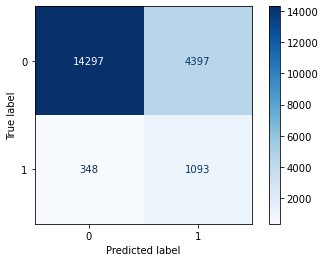

In [274]:
model_eval(gs_rf, 4, X_train_dum, y_train, X_test_dum, y_test, 'Random Forest with ADASYN2')